In [233]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon, Circle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry.polygon import Polygon as ShapelyPolygon

#for testing
import time

In [234]:
#The functions below make it easier to understand what information is being retrieved later in the code
#defines the value to use for max() to get third entity
def get_mult(ent):
    return ent[2]
#defines the value to use for max() to get second entity
def get_y(ent):
    return ent[1]
#defines the value to use for max() to get first entity
def get_x(ent):
    return ent[0]
#defines the value for the best score currently in a population
def get_best_score(ent):
    return ent[0]
#defines the value for the index at which the best drone layout is stored in population
def get_best_index(ent):
    return ent[1]

In [235]:
#GLOBAL VARIABLES

#stores the popultation - global variable so it can be accessed inside and outside functions
population = []

#Stores the list of drones for output; empty until filled by the algorithm
drone_list = []

#stores the best score currently in the population and the index at which the layout with the best score is located
best_fitness = (0, -1)

#Minimum coverage needed to be provided by the algorithm
#Format: decimal (1 = 100% coverage)
min_coverage = 1

#number of drones in each member of the population, starts at 1 unless changed
num_drones = 1

#population size for GA
pop_size = 500

#split ensures sum of 2 sections = whole pop_size on odd numbers
inherit_between_runs = int(pop_size/4)
remainder_of_pop = pop_size - inherit_between_runs

#total number of users in the network (set by loop below)
tot_users = 0

#list of "hot spots" 
#format: (x coordinate, y coordinate, multiplicity - number of users at that location)
map_density_list = np.array([(100,100,5), (400, 400, 1), (500, 1750, 6), (1500, 1500, 25), 
                             (0, 400, 10), (400, 0, 3), (1000, 1000, 5), (0, 800, 1), 
                             (800, 0, 1), (100, 0, 8), (1000, 300, 4), (400, 800, 10), 
                             (600, 550, 3), (900, 0, 9), (150,150,1), (650, 650, 1), 
                             (700, 700, 10), (690, 80, 15), (750, 100, 5), (50, 50, 5), (1000,400, 10)])
for (_,_,u) in map_density_list:
    tot_users += u

#fitness to strive for with GA
optimal_fitness = tot_users * min_coverage

#list of vertices in the polygon (in order of drawing)
#also calculates the minimum and maximum x and y values for the polygon
map_vertex_list = np.array([(0,0), (0, 2000), (2000,2000),(2000,0)])
xmin = get_x(min(map_vertex_list, key=get_x))
xmax = get_x(max(map_vertex_list, key=get_x))
ymin = get_y(min(map_vertex_list, key=get_y))
ymax = get_y(max(map_vertex_list, key=get_y))

#mutation rate for GA
#Format: decimal (1 = 100% (complete randomness))
mutation_rate = 0.01

#Creates two polygon objects used for later calculations
map_poly = Polygon(map_vertex_list, True)
shapely_poly = ShapelyPolygon(map_vertex_list)


print("Minimum Coverage: " + str(min_coverage * 100) + "%")
print("Number of drones in swarm: " + str(num_drones))
print("Population size for genetic algorithm: " + str(pop_size))
print("Total users in this map: " + str(tot_users))
print("Optimal fitness: " + str(optimal_fitness))
print("Mutation rate for genetic algorithm: " + str(mutation_rate * 100) + "%")

Minimum Coverage: 100%
Number of drones in swarm: 1
Population size for genetic algorithm: 500
Total users in this map: 138
Optimal fitness: 138
Mutation rate for genetic algorithm: 1.0%


In [236]:
#The section below calculates the height and coverage radius of the network module on the drone
#Parameters for the caclulation:
wavelength = 0.125
directivity_transmitter_dBi = 14
directivity_reciever_dBi = 5
power_transmitter_dBm = -10
power_reciever_dBm = -70
aperature_angle = 60

#convert angle in degrees to radians
theta = aperature_angle*(np.pi/180)

#calculations
height = wavelength / (4 * np.pi * 10**((power_reciever_dBm - 
                                         (power_transmitter_dBm + directivity_transmitter_dBi + 
                                          directivity_reciever_dBi))/20))
coverage_radius = int(height * np.tan(theta))
height = int(height)

print("Height: " + str(height) + " meters")
print("Coverage Radius: " + str(coverage_radius) + " meters")

Height: 88 meters
Coverage Radius: 153 meters


In [237]:
#checks if a point is within the map polygon
#returns boolean: true or false
def polygon_contains_point(point):
    point_to_check = ShapelyPoint(get_x(point), get_y(point))
    return shapely_poly.contains(point_to_check)

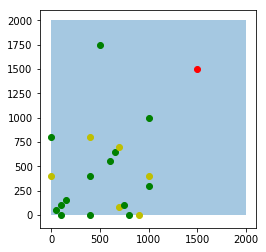

In [238]:
#draws appropriate map - make more flexible with different polygons
def draw_map(map_vertex_list, map_density_list, drone_list):
    
    patches = [map_poly]
    
    max_mult = get_mult(max(map_density_list, key=get_mult))
    #the following only runs after the computation has taken place and the drone positions have been calculated
    #handle drone selection circles
    for coord in drone_list:

        temp_circle = Circle(coord, radius=coverage_radius)
        patches.append(temp_circle)

    fig, ax = plt.subplots()
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    ax.add_collection(p)

    for coord in drone_list:
        plt.scatter(get_x(coord),get_y(coord),c='b')
    
    for (x, y, m) in map_density_list:
        if (m/max_mult) <= (1/3):
            plt.scatter(x, y, c='g')
        elif (m/max_mult) <= (2/3):
            plt.scatter(x, y, c='y')
        else:
            plt.scatter(x, y, c='r')
            
            
    plt.axis([xmin-10,xmax+10,ymin-10,ymax+10])
    plt.axis('scaled')
    plt.show()
    
draw_map(map_vertex_list, map_density_list, drone_list)

In [239]:
#GA SETUP

#fills population with pop_size random but appropriate entries
for _ in range(pop_size):
    temp_pop = []
    for _ in range(num_drones):
        add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
        while (not polygon_contains_point(add_to_pop)):
            add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
        temp_pop.append(add_to_pop)

    population.append(temp_pop)

def setup_intermediate():
    global population, drone_list, best_fitness, inherit_between_runs, remainder_of_pop
    add_to_pop = population[get_best_index(best_fitness)]
    population = []
    
    drone_list = []
    best_fitness = (0, -1)
    
    #fill some of the population with the winning entry from before
    for _ in range(inherit_between_runs):
        append = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
        while (not polygon_contains_point(append)):
            append = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
        temp = add_to_pop.copy()
        temp.append(append)
        population.append(temp)
    
    #fills remainder of the population with random but appropriate entries
    for _ in range(remainder_of_pop):
        temp_pop = []
        for _ in range(num_drones):
            add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            while (not polygon_contains_point(add_to_pop)):
                add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            temp_pop.append(add_to_pop)

        population.append(temp_pop)
    np.random.shuffle(population)


In [240]:
#GA DRAW functions

#append the fitness to every proposed map in population
    #fitness is defined as the number of users covered under a given map
def fitness():
    global best_fitness, population
    adj_population = []
    index = -1
    for proposed_map in population:
        score = 0
        cluster_exclusion_list = []
        for drone in proposed_map:

            for (x, y, m) in map_density_list:
                hot_spot = (x, y, m)
                dist = np.sqrt((get_x(hot_spot)-get_x(drone))**2 + (get_y(hot_spot)-get_y(drone))**2)
                if (dist <= coverage_radius and (hot_spot not in cluster_exclusion_list)):
                    cluster_exclusion_list.append(hot_spot)
                    for _ in range(get_mult(hot_spot)):
                        adj_population.append(proposed_map)
                    score += get_mult(hot_spot)
        index += 1
        if (score >= get_best_score(best_fitness)):
            best_fitness = (score, index)
    return adj_population

#Computes the next generation for the GA
#also handles mutation
def draw(adj_population):
    global population
    population = []
    mutation_check = 0
    for _ in range(pop_size):
        add_to_pop = []
        for m in range(num_drones):
            rand1 = np.random.randint(0, len(adj_population))
            rand2 = np.random.randint(0, len(adj_population))
            
            if (mutation_check == 1/mutation_rate):
                mut_rand = np.random.randint(0,2)
                if (mut_rand == 0):
                    add_to_pop.append((np.random.randint(xmin, xmax), get_y(adj_population[rand2][m])))
                else:
                    add_to_pop.append((get_x(adj_population[rand1][m]), np.random.randint(ymin, ymax)))
                mutation_check = 0
            else:
                add_to_pop.append((get_x(adj_population[rand1][m]), get_y(adj_population[rand2][m])))
        
        mutation_check += 1
        population.append(add_to_pop)
        
#graphically displays final result
def illustrate_final():
    global drone_list, population, best_fitness
    drone_list = population[get_best_index(best_fitness)]
    list_ = [list(elem) for elem in population[get_best_index(best_fitness)]]
    for tup in list_:
        tup.append(height)
    print("\nBest fitness: " + str(get_best_score(best_fitness)) + " \nProposed Map: " + str(list_))
    #illustrate solution
    draw_map(map_vertex_list, map_density_list, drone_list)

#displays intermediate results (failures)
def illustrate_intermediate():
    global best_fitness, num_drones
    if (num_drones == 1):
        print(str(num_drones) + " drone failed | Best fitness: " + str(get_best_score(best_fitness)) + 
              " \nContinuing with " + str(num_drones+1) + " drones")
    else:
        print(str(num_drones) + " drones failed | Best fitness: " + str(get_best_score(best_fitness)) + 
              "\nContinuing with " + str(num_drones+1) + " drones")

In [241]:
#loop for GA

#optimize: instead of max iterations, use for how many generations the fitness stays the same 
#(score stays the same for 50 iterations, move on)

#for testing
start_time = time.time()

intermediate = False

while(get_best_score(best_fitness) < optimal_fitness):
    if (intermediate):
        setup_intermediate()
    same_fitness_count = 0
    fit = fitness()
    #makes calculation time a function of these 2 variables
    #allows for more iterations for harder solutions
    calc_limit = int(num_drones * len(map_density_list)) /2
    while(get_best_score(best_fitness) < optimal_fitness and same_fitness_count < calc_limit):
        prev_fitness = get_best_score(best_fitness)
        draw(fit)
        fit = fitness()
        if (get_best_score(best_fitness) == prev_fitness):
            same_fitness_count += 1
        else:
            same_fitness_score = 0
    if (get_best_score(best_fitness) < optimal_fitness):
        illustrate_intermediate()
    num_drones += 1
    intermediate = True
illustrate_final()

1 drone failed | Best fitness: 30 
Continuing with 2 drones
2 drones failed | Best fitness: 55
Continuing with 3 drones
3 drones failed | Best fitness: 74
Continuing with 4 drones
4 drones failed | Best fitness: 88
Continuing with 5 drones
5 drones failed | Best fitness: 102
Continuing with 6 drones
6 drones failed | Best fitness: 112
Continuing with 7 drones
7 drones failed | Best fitness: 122
Continuing with 8 drones
8 drones failed | Best fitness: 128
Continuing with 9 drones
9 drones failed | Best fitness: 133
Continuing with 10 drones


KeyboardInterrupt: 

In [ ]:
#for testing
print('The algorithm took', time.time()-start_time, 'seconds.')

In [232]:
#old code:

In [ ]:
#OLD loop for GA
# fit = fitness()
# it = 0
# while(get_best_score(best_fitness) < optimal_fitness):
#     draw(fit)
#     print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
#     fit = fitness()
#     it += 1
# print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
# print("total generations: " + str(it))